In [3]:
# Importing  Libraries
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

In [4]:
# Setting Some Pre-Requisites
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000         # We will be training 80,000 samples from each label

In [7]:
import zipfile

files = [
    ("19fX3my59ZXswNmii7JnrMvJRlnGvWCO2", "sample_submission.csv"),
    ("14MD9_rKsNZpOFYQt06c3URjCY2g9CKpH", "test.zip"),
    ("1lJaKRCPsWRh-ofwbXuiEMT0uELU1LBDS", "train_labels.csv"),
    ("1OijjTK7qRDoPUoMpnRz39lKXWKWoj9Jq", "train.zip"),
]

for fid, name in files:
    os.system(f"gdown https://drive.google.com/uc?id={fid} -O /tmp/{name}")

# unzip train & test
for z in ["/tmp/train.zip", "/tmp/test.zip"]:
    with zipfile.ZipFile(z, "r") as f:
        f.extractall("/tmp")


Downloading...
From: https://drive.google.com/uc?id=19fX3my59ZXswNmii7JnrMvJRlnGvWCO2
To: /tmp/sample_submission.csv
100%|██████████| 2.47M/2.47M [00:00<00:00, 6.06MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14MD9_rKsNZpOFYQt06c3URjCY2g9CKpH
From (redirected): https://drive.google.com/uc?id=14MD9_rKsNZpOFYQt06c3URjCY2g9CKpH&confirm=t&uuid=31956865-dd3c-4a7c-ba0f-11adf3abc59d
To: /tmp/test.zip
100%|██████████| 1.40G/1.40G [00:23<00:00, 58.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lJaKRCPsWRh-ofwbXuiEMT0uELU1LBDS
To: /tmp/train_labels.csv
100%|██████████| 9.46M/9.46M [00:00<00:00, 9.59MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OijjTK7qRDoPUoMpnRz39lKXWKWoj9Jq
From (redirected): https://drive.google.com/uc?id=1OijjTK7qRDoPUoMpnRz39lKXWKWoj9Jq&confirm=t&uuid=a37f3b47-6b20-48e9-991a-983f4e7c0826
To: /tmp/train.zip
100%|██████████| 5.36G/5.36G [02:03<00:00, 43.3MB/s]


In [9]:
import os
os.listdir('/tmp')


['train_labels.csv',
 'test',
 'vscode-git-c236e40650.sock',
 'vscode-ipc-e7d463a4-f518-434c-8007-419af946cfb1.sock',
 'codespaces_logs',
 'test.zip',
 '_labels.csv',
 'dockerd.log',
 'python-languageserver-cancellation',
 'pyright-6961-KsZ8I2Ep47dJ',
 'vscode-ipc-9a3c6a2c-ae7e-4340-8f6e-7a20e5059927.sock',
 'vscode-ipc-cfa1048c-db06-45c8-8390-bb3f8e412bed.sock',
 'storage_version.txt',
 'system-commandline-sentinel-files',
 'sshd.log',
 'train.zip',
 'train',
 'sample_submission.csv']

In [10]:

train_dir = '/tmp/train'
test_dir = '/tmp/test'

print("Train images:", len(os.listdir(train_dir)))
print("Test images:", len(os.listdir(test_dir)))

Train images: 220026
Test images: 57458


In [11]:
df_data = pd.read_csv('/tmp/train_labels.csv')  # adjust path if needed

# Remove problematic images
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df_data.shape)

# Optional: Add full path column for easier access
df_data['filepath'] = df_data['id'].apply(lambda x: os.path.join('/tmp/train', f'{x}.tif'))

(220023, 2)


In [12]:
df_data['label'].value_counts()

label
0    130907
1     89116
Name: count, dtype: int64

In [13]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

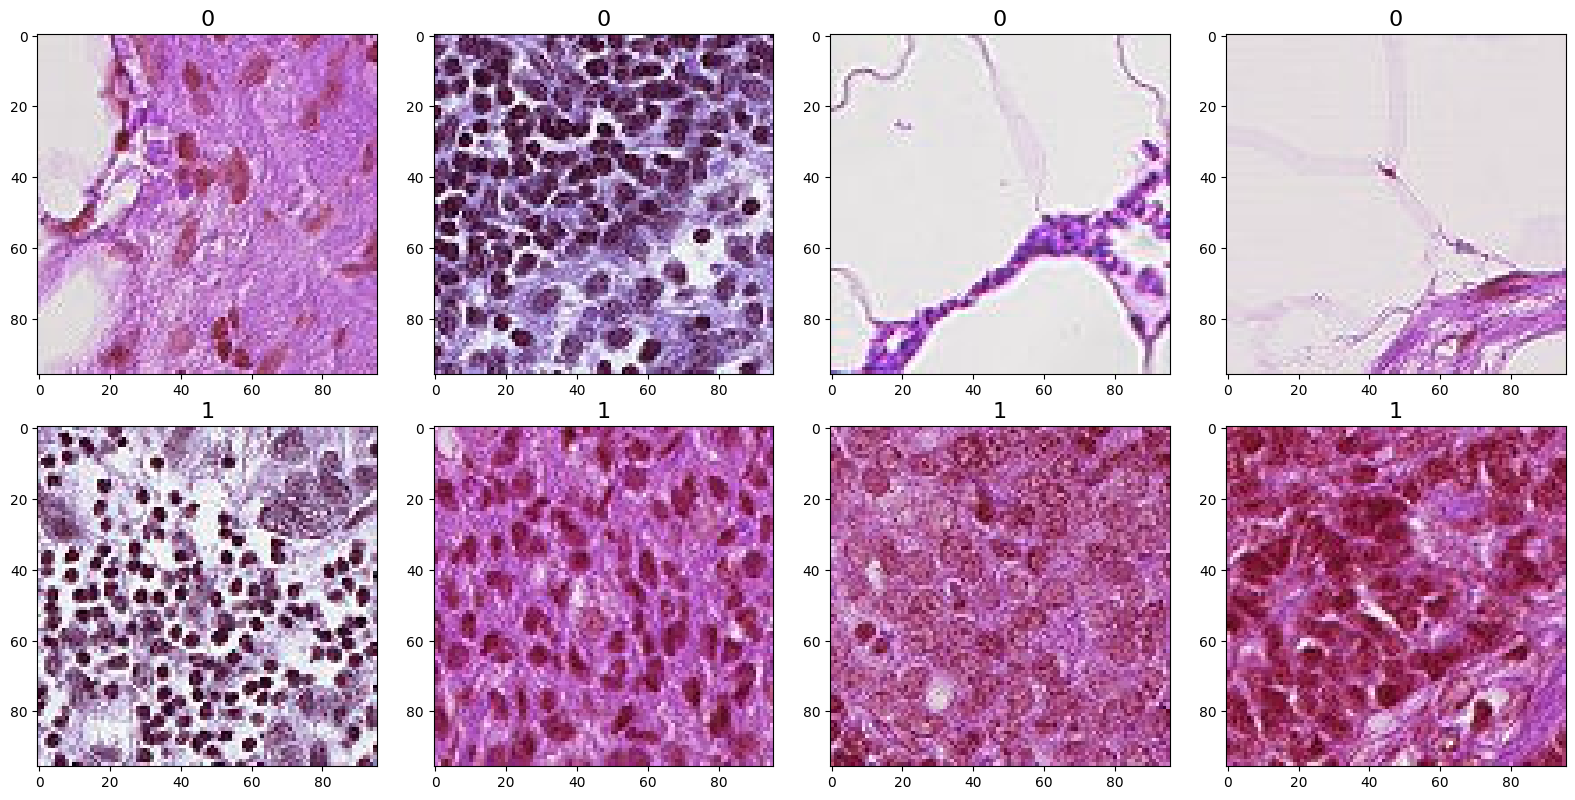

In [14]:
IMAGE_PATH = '/tmp/train/'  # corrected path

draw_category_images('label', 4, df_data, IMAGE_PATH)


In [15]:
# Create the Train and Validation Sets

df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

label
1    80000
0    80000
Name: count, dtype: int64

In [16]:
# Now, for the train-test split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 3)
(16000, 3)


In [17]:
# Create a new directory so that we will be using the ImageDataGenerator
base_dir='base_dir'
os.mkdir(base_dir)

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)



In [18]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['b_has_tumor_tissue', 'a_no_tumor_tissue']

In [19]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [28]:
# First, check the columns
print(df_data.columns)


Index(['label', 'filepath'], dtype='object')


In [29]:
import os
import shutil

# Base directory
base_dir = '/tmp/base_dir'
os.makedirs(base_dir, exist_ok=True)

# Train and validation directories
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Class subfolders
class_folders = ['a_no_tumor_tissue', 'b_has_tumor_tissue']
for folder in class_folders:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)

# Safe transfer function using 'filepath' directly
def transfer_images_from_filepath(df_subset, dest_dir):
    for _, row in df_subset.iterrows():
        src = row['filepath']
        target = row['label']
        label = 'a_no_tumor_tissue' if target == 0 else 'b_has_tumor_tissue'
        dst = os.path.join(dest_dir, label, os.path.basename(src))
        
        if not os.path.exists(src):
            print(f"Warning: source file {src} does not exist, skipping.")
            continue
        
        shutil.copyfile(src, dst)

# Assuming df_train and df_val are subsets of df_data
transfer_images_from_filepath(df_train, train_dir)
transfer_images_from_filepath(df_val, val_dir)


In [31]:
# Paths to folders
train_no_tumor = os.path.join(base_dir, 'train_dir', 'a_no_tumor_tissue')
train_has_tumor = os.path.join(base_dir, 'train_dir', 'b_has_tumor_tissue')
val_no_tumor = os.path.join(base_dir, 'val_dir', 'a_no_tumor_tissue')
val_has_tumor = os.path.join(base_dir, 'val_dir', 'b_has_tumor_tissue')

# Check how many train images we have in each folder
print(len(os.listdir(train_no_tumor)))   # e.g., 72000
print(len(os.listdir(train_has_tumor)))  # e.g., 72000

# Check how many val images we have in each folder
print(len(os.listdir(val_no_tumor)))     # e.g., 8000
print(len(os.listdir(val_has_tumor)))    # e.g., 8000


72000
72000
8000
8000


In [32]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96
train_batch_size = 32
val_batch_size = 32

datagen = ImageDataGenerator(rescale=1.0/255)

train_path = '/tmp/base_dir/train_dir'
valid_path = '/tmp/base_dir/val_dir'

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                      batch_size=val_batch_size,
                                      class_mode='categorical')

# Optional test generator
test_gen = datagen.flow_from_directory(valid_path,
                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='categorical',
                                       shuffle=False)


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [35]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [36]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [37]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
